Calculate Ocean Mixed Layer Budget using decomposition described in Zhang et. al. 2020 and Kang et. al. 2023

# Utils

In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from scipy.stats import linregress

In [2]:
# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    bound_region(ax1, lons=(-95, -70), lats=(-40, -5), color="black")
    # Southern Ocean
    bound_region(ax1, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    bound_region(ax1, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    bound_region(ax1, lons=(110, 165), lats=(-5, 5), color="black")

    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    

def create_scatter(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    CMIP6_label = "CMIP6"
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"CMIP5 r={r},p={p}"
        plt.scatter(x5, y5, s=40, color="#b2df8a", edgecolor="black") # , label=x.model.value)
        plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=150, color="#b2df8a", marker="x", label=CMIP5_label)
        plt.plot(np.array(x5), np.array(x5)*slope+intercept, color="#b2df8a", linestyle="--")

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        plt.plot(np.array(x6), np.array(x6)*slope+intercept, color="#a6cee3", linestyle="--")
        CMIP6_label = f"CMIP6 r={r},p={p}"
    
    plt.scatter(x6, y6, s=40, edgecolor="black", color="#a6cee3") # , label=x.model.value)
    plt.scatter(np.mean(x6), np.mean(y6), s=150, edgecolor="black", color="#a6cee3", marker="x", label=CMIP6_label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if len(vline) >= 1:
        plt.vlines(vline[0], ymin=0, ymax=.6, color="red", linestyle="--", label="ERA5")
    if len(vline) >= 2:
        plt.vlines(vline[1], ymin=0, ymax=.6, color="blue", linestyle="--", label="NOAA")
    if len(vline) >= 3:
        plt.vlines(vline[2], ymin=0, ymax=.6, color="green", linestyle="--", label="COBE2")

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--")
    plt.legend()
    
    plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r},p={p}", loc="right", fontweight="bold")


def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def remove_land_full(ds, var="skt"):
    ds = ds.rename(var).to_dataset()
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def drop_bad_models(ds1: xr.Dataset, era: str = "cmip6") -> xr.Dataset:
    # Verify that both datasets have the same models

    if era == "cmip6":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('CanESM5-1')
        sub.remove('CanESM5')
        sub.remove('NESM3')
        sub.remove('BCC-ESM1')
        if 'CAMS-CSM1-0' in sub: sub.remove('CAMS-CSM1-0')

    if era == "cmip5":
        sub = list(ds1.model.values)
        print(sub)
        sub.remove('BNU-ESM')
        sub.remove('CanESM2')
        sub.remove('FIO-ESM')
        sub.remove('CMCC-CESM')
        sub.remove('MPI-ESM-P')
        sub.remove('MRI-CGCM3')
        sub.remove('inmcm4')
        sub.remove('CMCC-CM')

    ds1 = ds1.sel(model=sub)

    return ds1

In [3]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a DataArray

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 12*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}.nc")

    grads = np.full((data.model.size, int((len(data.time) - window) / step), data.lat.size, data.lon.size), np.nan)
    print(grads.shape)
    time_idx = xr.DataArray(np.arange(window, dtype="float"), dims="time")
    # time_idx = xr.DataArray(np.arange(12*30), dims=("time"))

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        # print(i, i+window)
        if j % 10 == 0: print(j)
        grads[:,j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        

    # Convert to xarray
    da =  xr.DataArray(grads, dims=("model", "time", "lat", "lon"), coords={"model": data.model, "lat": data.lat, "lon": data.lon, "time": np.arange(grads.shape[1])})
    
    if save:
        da.to_netcdf(f"data/piControl/rolling_gradient_{name}.nc")
    
    return da

# from scipy.stats import linregress
# SW_anoms = xr.merge([SW, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
# SW_anoms = SW_anoms.temporal.departures("SW", "month")
# sw_test = SW_anoms.sel(model="CESM2").isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')

# sw_test = SW.sel(model=["CESM2"]).isel(time=slice(0, 12*30)).sel(lat=slice(0, 5), lon=slice(0, 5)) #, method='nearest')
# print(sw_test)
# time_idx = xr.DataArray(np.arange(12*30, dtype="float"), dims="time")
# # res = linregress(time_idx, sw_test)
# print(res)
# res = xscore.linslope(time_idx, sw_test, dim='time', skipna=True)
# print(res)
# # plt.plot(time_idx, sw_test)

# da = calculate_rolling_gradient(sw_test, save=True, name="SW")
# da.values #/ (12*30)

# Process the surface energy budget data

In [4]:
fluxes = [
        "rlds", # surface downwelling longwave flux, all sky
        "rldscs", # surface downwelling longwave flux, clear sky
        "rsds", # surface downwelling shortwave flux, all sky
        "rsdscs", # surface downwelling shortwave flux, clear sky
        "rlus", # surface upwelling longwave flux, all sky
        "rsus", # surface upwelling shortwave flux, all sky (probably don't need)
        "rsuscs", # surface upwelling shortwave flux, clear sky (probably don't need)
        "hfls", # surface upward latent heat flux
        "hfss", # surface upward shortwave heat flux
        "sfcWind", # surface wind speed
        "hur", # surface relative humidity
        "tos", # sea surface temperature
        "tas", # surface air temperature
]
ERA = "CMIP6"

In [5]:
ds = {}
for flux in fluxes: 
    ds[flux] = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")[flux]

ds_raw = xc.open_dataset(f"data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")

# Calculate Surface Energy Budget Terms
LW = (ds["rlds"] - ds["rlus"]).rename("LW") # Net Downward Longwave Radiation
LWC = (LW - ds["rldscs"]).rename("LWC") # Cloud Net Downward Longwave Radiation
SW = (ds["rsds"] - ds["rsus"]).rename("SW") # Net Downward Shortwave Radiation
SWC = (SW - (ds["rsdscs"] - ds["rsuscs"])).rename("SWC") # Cloud Net Downward Shortwave Radiation
DT = (ds["tas"] - 273.15 - ds["tos"]).rename("DT") # Low Atmosphere Stability
SH = ds["hfss"].rename("SH") # Net Upward Sensible Heat Flux
LH = ds["hfls"].rename("LH") # Net Upward Latent Heat Flux
TOS = ds["tos"].rename("TOS") # Sea Surface Temperature
RH = ds["hur"].rename("RH") # Relative Humidity
W = ds["sfcWind"].rename("W") # Wind Speed

LH_Bar = LH.mean("time")
RH_Bar = RH.mean("time")
W_Bar = W.mean("time")
DT_Bar = DT.mean("time")

Lv = 2.5e6 # Latent Heat of Vaporization
Rv = 461.5 # Gas Constant for Water Vapor
alpha = Lv/(Rv*(TOS.mean("time")+273.15)**2)

In [7]:
# Merge all terms into one dataset
print("Merging datasets...")
# ds_seb = [LW, LWC, SW, SWC, SH, LH, TOS, RH, W, DT] 
ds_seb = [RH]

# Calculate Anomalies
print("Calculating Anomalies...")
ds_trends = {}
SAVE = True
for i, var in enumerate(ds_seb): 
    ds_var = xr.merge([var, ds_raw["lon_bnds"], ds_raw["lat_bnds"], ds_raw["time_bnds"]])
    for var_name in ds_var: 
        print(f"Calculating Anomalies for {var_name}...")
        ds_anoms = ds_var.temporal.departures(var_name, "month")
        ds_trends[var_name] = calculate_rolling_gradient(ds_var[var_name], save=SAVE, name=var_name)
        break

Merging datasets...
Calculating Anomalies...
Calculating Anomalies for RH...
(52, 120, 72, 144)
0


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:99: RuntimeWarning: Mean of empty slice
  mb = meanfunc(b, axis=axis)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic

10


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

20


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

30


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

40


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

50


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

60


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

70


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

80


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

90


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

100


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

110


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_dete

# Calculate tendency terms
Note to self: All of these forcing tendencies have been multiplied by 12*30 (i.e. they are 30 year trends) except for RH. To convert to 10 year trends, simply divide by 3

In [6]:
def get_shared_models(vars):
    models = []
    for var in vars:
        models.append(var.model.values)
    shared_models = list(set.intersection(*map(set, models)))
    return shared_models

SH_T = drop_bad_models(xr.open_dataarray("data/piControl/rolling_gradient_SH.nc"), era="cmip6")
LH_T = xr.open_dataarray("data/piControl/rolling_gradient_LH.nc")
LW_T = xr.open_dataarray("data/piControl/rolling_gradient_LW.nc")
LWC_T = xr.open_dataarray("data/piControl/rolling_gradient_LWC.nc")
SW_T = xr.open_dataarray("data/piControl/rolling_gradient_SW.nc")
SWC_T = xr.open_dataarray("data/piControl/rolling_gradient_SWC.nc")
W_T = xr.open_dataarray("data/piControl/rolling_gradient_W.nc")
RH_T = xr.open_dataarray("data/piControl/rolling_gradient_RH.nc")
DT_T = xr.open_dataarray("data/piControl/rolling_gradient_DT.nc")
TOS_T = xr.open_dataarray("data/piControl/rolling_gradient_TOS.nc")

shared_models = get_shared_models([SH_T, LH_T, LW_T, LWC_T, SW_T, SWC_T, W_T, RH_T, DT_T, TOS_T, RH_Bar, LH_Bar, DT_Bar, W_Bar, alpha])

SH_T = SH_T.sel(model=shared_models)
LH_T = LH_T.sel(model=shared_models) 
LW_T = LW_T.sel(model=shared_models) 
LWC_T = LWC_T.sel(model=shared_models) 
SW_T = SW_T.sel(model=shared_models) 
SWC_T = SWC_T.sel(model=shared_models) 
W_T = W_T.sel(model=shared_models) 
RH_T = RH_T.sel(model=shared_models) 
DT_T = DT_T.sel(model=shared_models) 
TOS_T = TOS_T.sel(model=shared_models)/3

RH_Bar = RH_Bar.sel(model=shared_models) 
RH_Bar = RH_Bar.drop("plev")
LH_Bar = LH_Bar.sel(model=shared_models) 
DT_Bar = DT_Bar.sel(model=shared_models) 
W_Bar = W_Bar.sel(model=shared_models) 
alpha = alpha.sel(model=shared_models) 

print("Number of shared models: ", len(shared_models))

['E3SM-1-1', 'E3SM-1-0', 'KIOST-ESM', 'CIESM', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2', 'FGOALS-f3-L', 'CAS-ESM2-0', 'FGOALS-g3', 'SAM0-UNICON', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-2-H', 'GISS-E2-1-H', 'GISS-E2-2-G', 'GISS-E2-1-G', 'IITM-ESM', 'CanESM5', 'CAMS-CSM1-0', 'MCM-UA-1-0', 'KACE-1-0-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM', 'TaiESM1', 'EC-Earth3-LR', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-AerChem', 'CMCC-ESM2', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'MRI-ESM2-0', 'ACCESS-CM2', 'NESM3', 'MIROC6', 'IPSL-CM6A-LR', 'NorESM1-F', 'NorCPM1', 'FIO-ESM-2-0', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'AWI-CM-1-1-MR', 'EC-Earth3-CC', 'NorESM2-MM', 'E3SM-2-0', 'CanESM5-1', 'E3SM-2-0-NARRM']
Number of shared models:  36


In [7]:
# Convert from K/30yrs to K/decade by dividing by 3

# Ocean Heat Transport
O_T = LW_T + SW_T - SH_T - LH_T # Calculate ocean heat transport as residual
# Ocean Heat Transport Tendency
O_T = -O_T/(alpha*LH_Bar)/3
# Sensible Heat Flux Tendency
SH_T = SH_T/(alpha*LH_Bar)/3
# Longwave Radiative Forcing
LW_T = LW_T/(alpha*LH_Bar)/3
# Shortwave Radiative Forcing
SW_T = SW_T/(alpha*LH_Bar)/3
# Latent Heat Flux Tendency
LH_TW = W_T/(alpha*W_Bar)/3 # Wind Driven
LH_TRH = (RH_T*12*30)/(alpha*(np.exp(alpha*DT_Bar) - RH_Bar))/3 # Relative Humidity Driven
LH_TDT = RH_Bar*DT_T/(np.exp(alpha*DT_Bar) - RH_Bar)/3 # Temperature Driven
LH_TDT = LH_TDT.transpose("model", "time", "lat", "lon")
# Cloud Radiative Forcing
LWC_T = LWC_T/(alpha*LH_Bar)/3
SWC_T = SWC_T/(alpha*LH_Bar)/3

NET = O_T + LW_T + SW_T - SH_T - LH_TW - LH_TRH - LH_TDT 


## Sanity Check

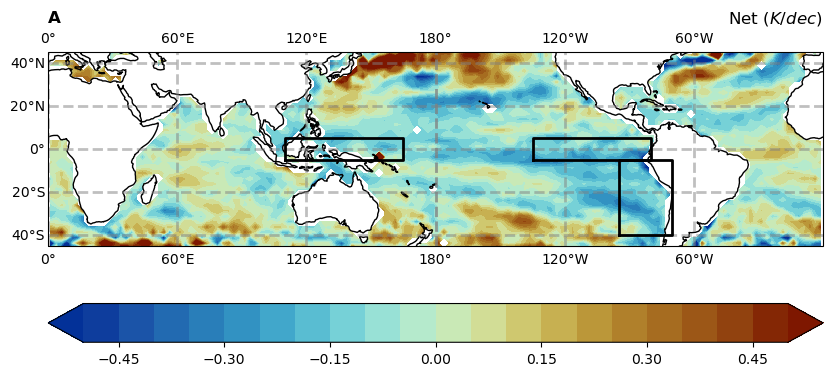

In [8]:
global_plot(
    data=(SW_T + LW_T - LH_TW - LH_TRH - LH_TDT + O_T - SH_T).sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SW.lat,
    lon=SW.lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="A", 
    right_title="Net $(K/dec)$"
)

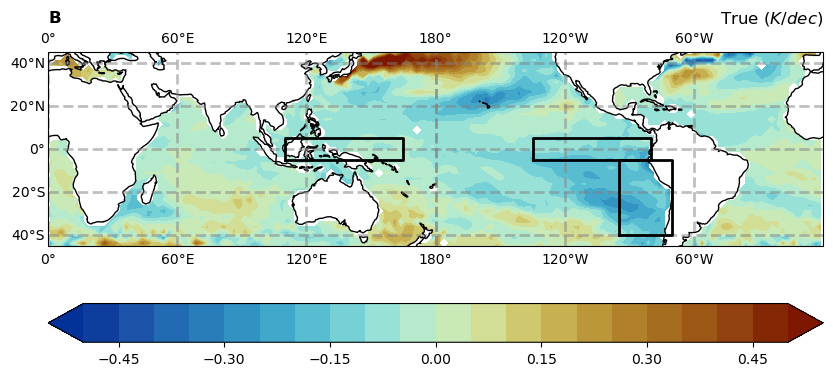

In [9]:

global_plot(
    data=(TOS_T).sel(model="HadGEM3-GC31-MM").isel(time=1), 
    lat=SW.lat,
    lon=SW.lon,
    pvalues=None, 
    levels=np.arange(-.5, .55, .05),
    cmap=cmc.roma_r, 
    left_title="B", 
    right_title="True $(K/dec)$"
)

# SEB Composites

In [8]:
# Load Rolling Gradient for Regions TOS
SST_T_EPSA = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc").sel(model=shared_models)
SST_T_WE = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend.nc").sel(model=shared_models)
SST_T_E = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacific_trend.nc").sel(model=shared_models)
SST_T_SO = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc").sel(model=shared_models)


In [61]:
# def fix_coords(data):
#     print(data)
#     data = data.bounds.add_bounds("X")
#     data = data.bounds.add_bounds("Y")
#     data = xc.swap_lon_axis(data, to=(-180, 180))
#     return data

def get_regions(flux):
    name = "filler"
    flux = fix_coords(flux.rename(name).to_dataset())

    # WE
    flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
    flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    flux_WE = (flux_west - flux_east).mean("time", skipna=True)

    # EPSA
    flux = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
    flux_EPSA = flux.mean("time", skipna=True)

    # SO
    flux = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
    flux_SO = flux.mean("time", skipna=True)

    # EP
    flux = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    flux_EP = flux.mean("time", skipna=True)

    return (flux_WE, flux_EPSA, flux_SO, flux_EP)

def composite_sigma_anoms(X, Y, remove_land=True):
    dsX, dsY, dsY_regions = [], [], []

    for model in X.model:
        cX = X.sel(model=model)
        cY = Y.sel(model=model)
        idxMax = cX > (cX.mean("time") + cX.std("time"))

        cX_max = cX[idxMax].mean("time")
        cY_max = cY[idxMax, :, :].mean("time")

        # if remove_land:
        #     cY_max = fix_coords(cY_max.rename("filler").to_dataset())
        #     cY_max = remove_land_full(ds=cY_max, var="filler")
        
        cY_max_regions = get_regions(cY_max)

        dsX.append(cX_max)
        dsY.append(cY_max)
        dsY_regions.append(cY_max_regions)

    # convert to DataArray
    dsX = xr.concat(dsX, dim="model")
    dsY = xr.concat(dsY, dim="model")
    dsY_regions = xr.concat(dsY_regions, dim="model")


    return dsX, dsY, dsY_regions

In [62]:
def plot_sigma_anoms(var_names, vars, SST_T, region="EPSA"):
    for i, (name, flux) in enumerate(zip(var_names, vars)):
        print(name)
        _, flux_sig = composite_sigma_anoms(X=SST_T, Y=flux)
        # Plot Individual SEB 
        global_plot(
            data=flux_sig.mean("model"),
            lat=flux_sig.lat,
            lon=flux_sig.lon,
            pvalues=None, 
            levels=np.arange(-.26, .28, .02),
            # levels=np.arange(0, .32, .02),
            cmap=cmc.roma_r, 
            # cmap=cmc.batlowW, 
            left_title=labels[i], 
            right_title=f"{name} $(K/dec)$"
        )
        plt.savefig(f"figures/seb/mean_{name}_{region}.png")
        plt.show()

var_names = ["TOS", "NET", "SH", "O", "SW", "LW", "LWC", "SWC", r"LH$_{others}$", r"LH$_w$", r"LH$_{\Delta T}$", r"LH$_{RH}$"]
vars = [TOS_T, NET, -SH_T, O_T, SW_T, LW_T, LWC_T, SWC_T, -(LH_TW + LH_TDT + LH_TRH),-LH_TW, -LH_TDT, -LH_TRH]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

plot_sigma_anoms(var_names, vars, SST_T_EPSA, region="EPSA")


TOS
<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144)
Coordinates:
    model    <U13 'MPI-ESM1-2-LR'
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    filler   (lat, lon) float64 0.0 0.0 0.0 ... -1.048e-05 -9.752e-06 -8.948e-06


ValueError: Cannot generate bounds for coordinate variable 'model' which has a length <= 1 (singleton).

# SEB Variance Analysis

In [24]:
def scatter_plot_seb(var_names, vars, SST_T, SST_region="EPSA", flux_region="WE", scatter=True):
    flux_mean = {}
    for i, (name, flux) in enumerate(zip(var_names, vars)):
        print(name)
        flux = fix_coords(flux.rename(name).to_dataset())

        if flux_region == "WE":
            flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
            flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
            flux = (flux_west - flux_east).std("time")
            flux_mean[name] = (flux_west - flux_east).mean("time", skipna=True)
        elif flux_region == "EPSA":
            flux = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]
            flux_mean[name] = flux.mean("time", skipna=True)
            flux = flux.std("time")
        elif flux_region == "SO":
            flux = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]
            flux_mean[name] = flux.mean("time", skipna=True)
            flux = flux.std("time")
        elif flux_region == "EP":
            flux = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
            flux_mean[name] = flux.mean("time", skipna=True)
            flux = flux.std("time")
        else: 
            raise ValueError("Invalid flux region")

        # Plot Individual SEB 
        if scatter:
            create_scatter(
                x6=flux, 
                y6=(SST_T).std("time"), 
                vline=[],
                xlabel=f"$\sigma$({name} Trend) {flux_region}", 
                ylabel=f"$\sigma$(SST Trend) {SST_region}",
            )

            plt.savefig(f"figures/seb/{name}_scatter_flux{flux_region}_sst{SST_region}.png")
            plt.show()

    return flux_mean

var_names = ["TOS", "NET", "O", "SW", "SWC", "LW", "LWC", "SH", r"$LH_{other}$"] #, r"LH$_w$", r"LH$_{\Delta T}$", r"LH$_{RH}$"]
vars = [TOS_T, NET, O_T, SW_T, SWC_T, LW_T, LWC_T, -SH_T, -(LH_TW + LH_TDT + LH_TRH)] #,-LH_TW, -LH_TDT, -LH_TRH]
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

flux_mean = scatter_plot_seb(var_names, vars, SST_T_WE/3, SST_region="WE", flux_region="WE", scatter=False)
print(flux_mean)


TOS
NET
O
SW
SWC
LW
LWC
SH
$LH_{other}$
{'TOS': <xarray.DataArray 'TOS' (model: 36)>
array([ 9.04032320e-03,  4.88588970e-03, -6.59558309e-03,  7.45501401e-03,
        8.32703653e-03, -4.85351897e-03,  6.06709322e-03, -3.46342911e-03,
        1.97665652e-03, -8.34818081e-03, -1.69502520e-03,  1.52642637e-03,
       -1.52450669e-02, -7.21691847e-04, -8.80702515e-03, -4.31808113e-03,
        1.60165353e-02,  2.77306775e-03, -2.21541337e-04,  1.18470801e-02,
       -9.08727365e-03,  5.66141032e-03, -3.21123214e-03, -6.48267427e-03,
        2.35040611e-03, -3.28717701e-03,  1.50597024e-02, -6.35242737e-03,
        1.55861733e-02, -1.49307942e-02, -1.43458524e-03, -1.68887947e-04,
       -9.29179464e-05,  1.11074740e-03,  3.37918321e-02,  2.11934675e-02])
Coordinates:
  * model    (model) object 'MPI-ESM1-2-LR' 'GFDL-ESM4' ... 'E3SM-2-0', 'NET': <xarray.DataArray 'NET' (model: 36)>
array([ 0.01639345, -0.00797431,  0.41862658, -0.0042885 ,  0.08050491,
       -0.02477936,  0.0184812 , -0.01

In [33]:
import seaborn as sns

def violin_plot_tos(tos, title):
    fig = plt.figure()
    sns.set_palette("husl")
    sns.violinplot(data=tos, inner="box", width=8)
    # plt.title(title + r" SST$_{EPSA}$ Trend ($K/Dec$)")
    plt.grid()
    plt.xticks(fontsize=15)
    # Rotate the y-axis labels
    plt.tick_params(axis='x')
    fig.set_size_inches(15, 5)
    plt.xlabel("")
    plt.title(r"SST$_{WE}$ Trend ($K/Dec$)", fontsize=15, loc="right", weight="bold")

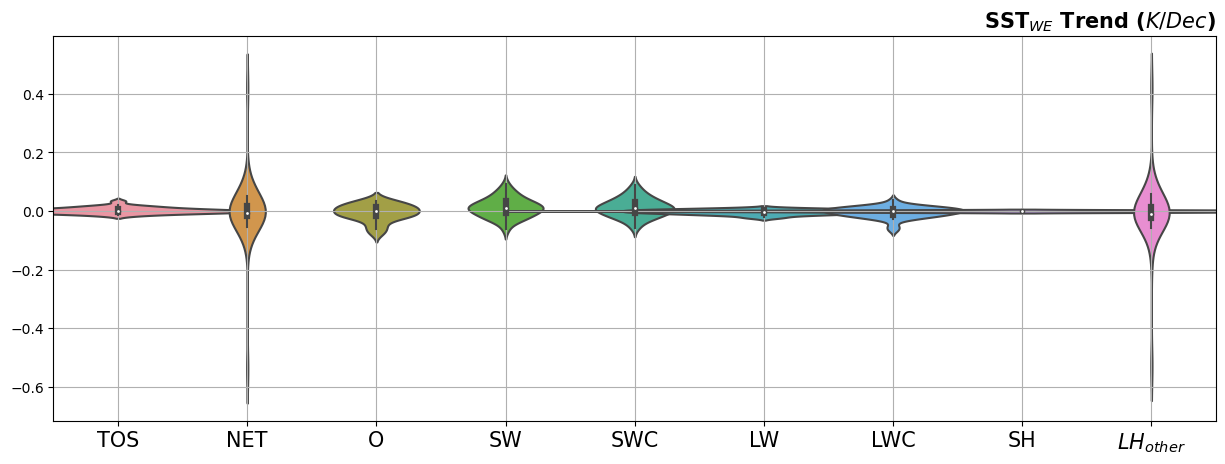

In [34]:
import pandas as pd

violin_plot_tos(pd.DataFrame(flux_mean), title="CMIP6")